In [32]:
import os
import math
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt

In [33]:
# https://www.fao.org/faostat/en/#data/QCL

DATA_PATH = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '.', 'FAOSTAT.csv')
DATA_PATH2 = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '.', 'FAOSTAT_2022.csv')
ITEM_NAME = 'Coffee, green'
ELEMENT_NAME = 'Production'

Выборка:
===== Набор данных: FAOSTAT_2022 (год 2022) =====
   Domain Code                        Domain  Area Code (M49)  \
0          QCL  Crops and livestock products               24   
1          QCL  Crops and livestock products               84   
2          QCL  Crops and livestock products              204   
3          QCL  Crops and livestock products               68   
4          QCL  Crops and livestock products               76   
..         ...                           ...              ...   
77         QCL  Crops and livestock products              862   
78         QCL  Crops and livestock products              704   
79         QCL  Crops and livestock products              887   
80         QCL  Crops and livestock products              894   
81         QCL  Crops and livestock products              716   

                                  Area  Element Code     Element  \
0                               Angola          5510  Production   
1                       

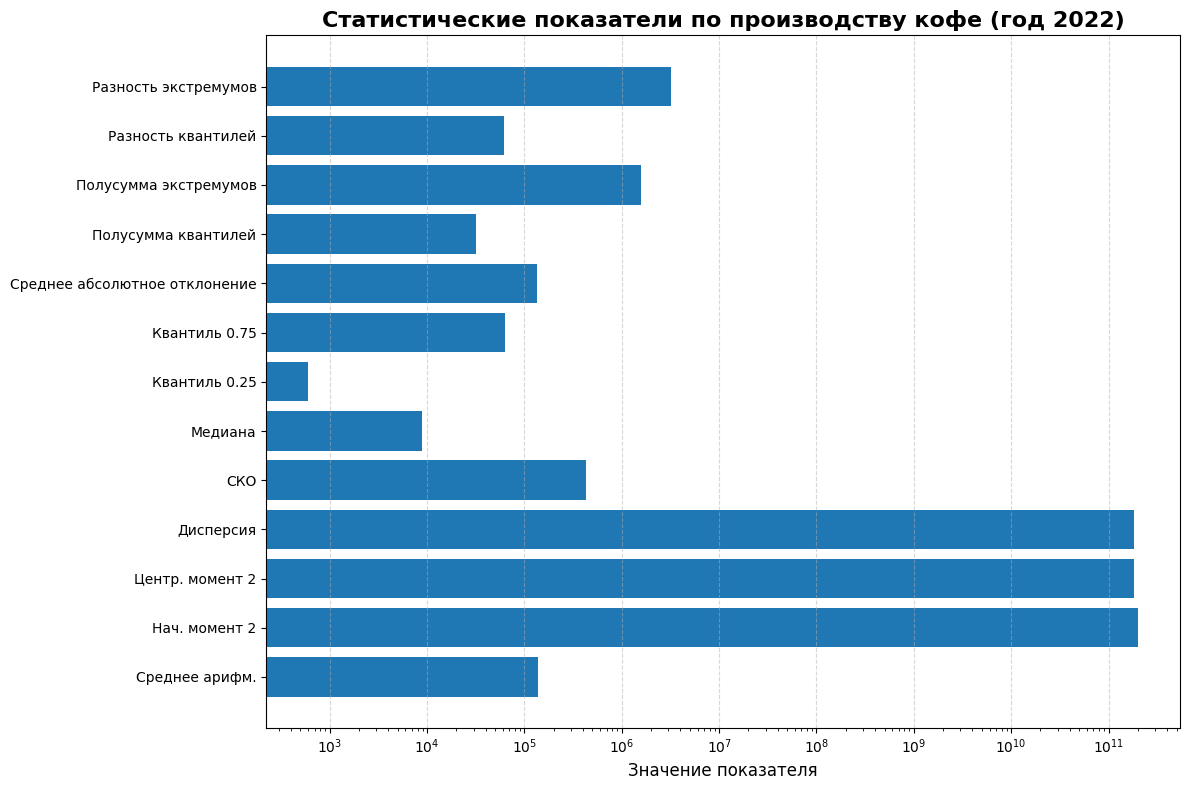

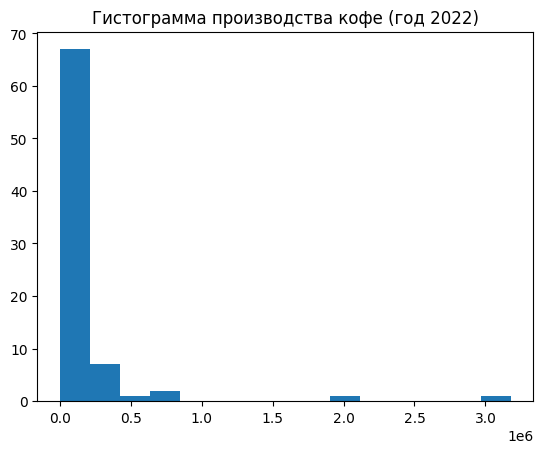

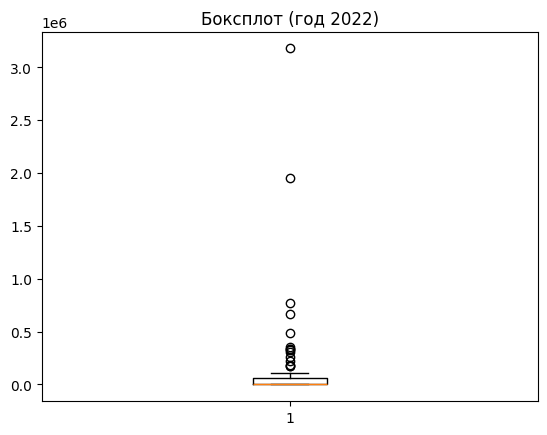

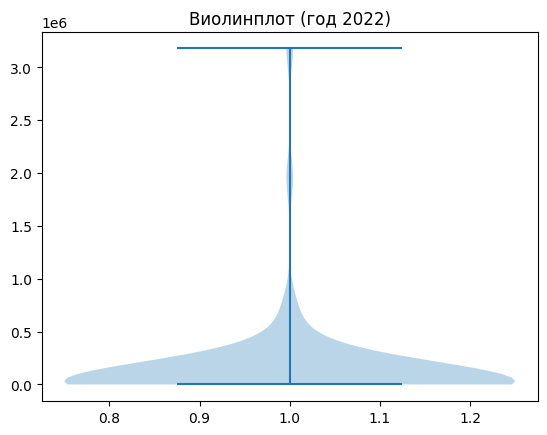

Выборка:
===== Набор данных: FAOSTAT (год 2023) =====
   Domain Code                        Domain  Area Code (M49)  \
0          QCL  Crops and livestock products               24   
1          QCL  Crops and livestock products               84   
2          QCL  Crops and livestock products              204   
3          QCL  Crops and livestock products               68   
4          QCL  Crops and livestock products               76   
..         ...                           ...              ...   
77         QCL  Crops and livestock products              862   
78         QCL  Crops and livestock products              704   
79         QCL  Crops and livestock products              887   
80         QCL  Crops and livestock products              894   
81         QCL  Crops and livestock products              716   

                                  Area  Element Code     Element  \
0                               Angola          5510  Production   
1                            

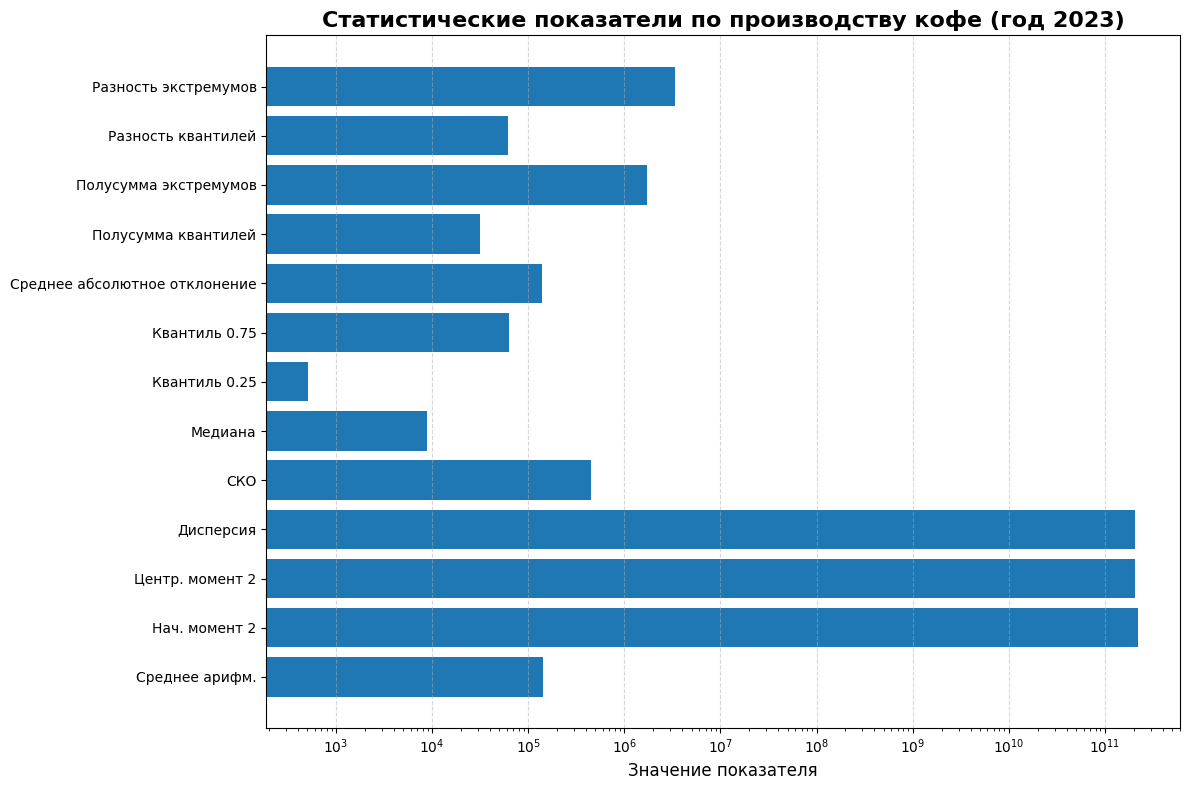

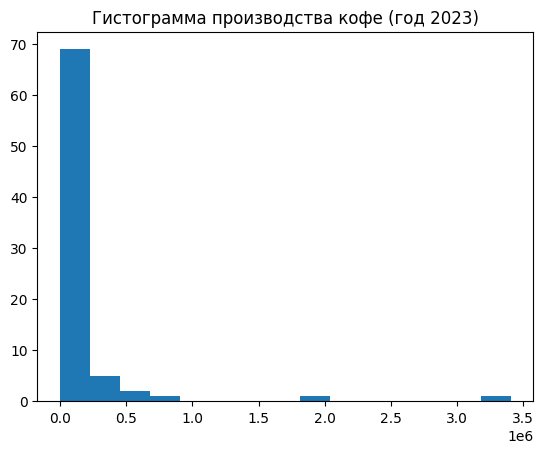

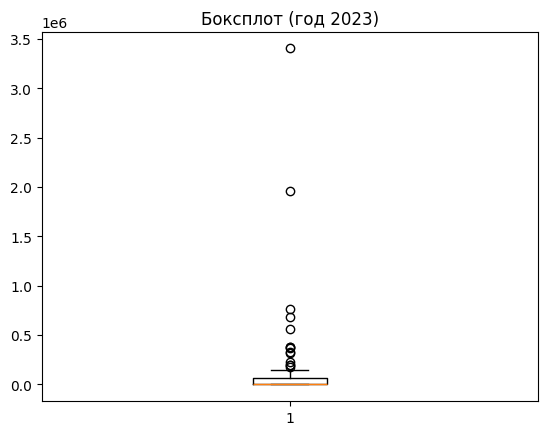

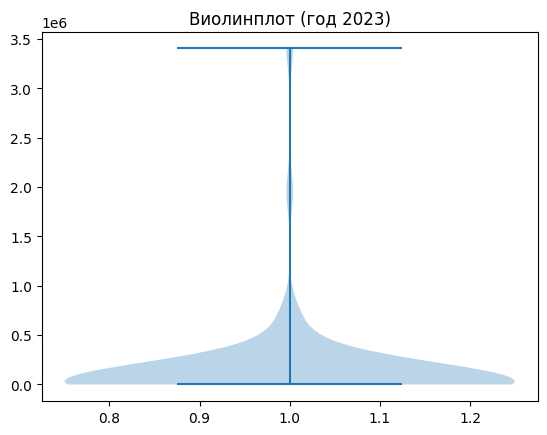

In [34]:
cols_expected = [
    'Domain Code','Domain','Area Code (M49)','Area','Element Code','Element',
    'Item Code (CPC)','Item','Year Code','Year','Unit','Value','Flag','Flag Description','Note'
]

for label, path in [("FAOSTAT_2022", DATA_PATH2), ("FAOSTAT", DATA_PATH)]:
    df = pd.read_csv(path)

    missing_cols = {'Area', 'Element', 'Item', 'Year', 'Unit', 'Value'} - set(df.columns)
    if missing_cols:
        raise ValueError(f'Во входном файле отсутствуют необходимые колонки: {missing_cols}')

    # фильтр: кофе, производство
    mask = (df['Item'] == ITEM_NAME) & (df['Element'] == ELEMENT_NAME)
    df = df.loc[mask].copy()

    # чистка типов
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

    df = df.dropna(subset=['Value'])

    # выберем год с максимальным покрытием
    df_year_counts = df.groupby('Year')['Value'].count().sort_values(ascending=False)
    chosen_year = df_year_counts.index[0]

    df_year = df[df['Year'] == chosen_year].copy()

    print(f"Выборка:\n===== Набор данных: {label} (год {chosen_year}) =====")
    print(df_year)

    ranking = df_year[['Area', 'Value']].sort_values('Value', ascending=False).reset_index(drop=True)
    print('\nТоп-10 производителей кофе (тонны):')
    print(ranking.head(10).to_string(index=False))

    top_area = ranking.iloc[0]['Area']
    top_value = ranking.iloc[0]['Value']
    print(f"\nСтрана-лидер по производству кофе в {chosen_year}: {top_area} — {top_value:,.0f} т")

    # берём уникальные значения производства
    m = np.array(list(set(df_year["Value"])))
    print("\nКоличество уникальных значений:", len(m))

    n = len(m)

    # статистики
    l = 2
    mean_v = m.mean()
    al = (m ** l).mean()
    ml = ((m - mean_v) ** l).mean()
    s2 = ((m - mean_v) ** 2).mean()
    sigma = math.sqrt(s2)
    med = np.median(m)
    q25 = np.quantile(m, 0.25)
    q75 = np.quantile(m, 0.75)
    mad = np.mean(np.abs(m - med))
    hs_q = (q75 + q25) / 2
    hs_ex = (m.max() + m.min()) / 2
    dq = q75 - q25
    de = m.max() - m.min()

    if label == "FAOSTAT_2022":
        s2_2022 = s2
        n_2022  = n
    elif label == "FAOSTAT":
        s2_2023 = s2
        n_2023  = n

    print("1) Среднее арифметическое =", mean_v)
    print(f"2) Выборочный начальный момент порядка {l} =", al)
    print(f"3) Выборочный центральный момент порядка {l} =", ml)
    print("4) Дисперсия =", s2)
    print("5) Среднее квадратичное отклонение =", sigma)
    print("6) Медиана =", med)
    print("7) Квантиль 0.25 =", q25)
    print("7) Квантиль 0.75 =", q75)
    print("8) Среднее абсолютное отклонение =", mad)
    print("9) Полусумма квантилей =", hs_q)
    print("10) Полусумма экстремумов =", hs_ex)
    print("11) Разность квантилей =", dq)
    print("12) Разность экстремумов =", de)

    s_max = max(s2_2022, s2_2023)
    s_min = min(s2_2022, s2_2023)

    F = s_max / s_min

    # проверка гипотезы о равенстве дисперсий через f-test
    # f_statistic = s_max / s_min
    # p_value = f.cdf(f_statistic, (len(m)-1), len(m)-1)
    # print("F-Statistic:", f_statistic)
    # print("P-value:", p_value)

    # степени свободы
    d1 = n_2022 - 1
    d2 = n_2023 - 1

    alpha = 0.05  # уровень значимости

    # критические точки находим квантиль распределения Фишера
    F_left  = f.ppf(alpha/2,     dfn=d1, dfd=d2)
    F_right = f.ppf(1-alpha/2,   dfn=d1, dfd=d2)

    # подготовка к графикам
    x1 = mean_v
    x2 = med
    x3 = q25
    x4 = q75
    x5 = mad
    x6 = hs_q
    x7 = hs_ex
    x8 = dq
    x9 = de

    # график статистических показателей
    plt.figure(figsize=(12, 8))
    labels = [
        "Среднее арифм.",
        f"Нач. момент {l}",
        f"Центр. момент {l}",
        "Дисперсия",
        "СКО",
        "Медиана",
        "Квантиль 0.25",
        "Квантиль 0.75",
        "Среднее абсолютное отклонение",
        "Полусумма квантилей",
        "Полусумма экстремумов",
        "Разность квантилей",
        "Разность экстремумов"
    ]

    values = [
        x1, al, ml, s2, sigma, x2, x3,
        x4, x5, x6, x7, x8, x9
    ]

    plt.barh(labels, values)
    plt.xscale("log")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.title(f"Статистические показатели по производству кофе (год {chosen_year})", fontsize=16, fontweight='bold')
    plt.xlabel("Значение показателя", fontsize=12)
    plt.tight_layout()
    plt.show()

    # гистограмма
    plt.figure()
    plt.hist(m, bins=15)
    plt.title(f"Гистограмма производства кофе (год {chosen_year})")
    plt.show()

    plt.figure()
    plt.boxplot(m)
    plt.title(f"Боксплот (год {chosen_year})")
    plt.show()

    plt.figure()
    plt.violinplot(m)
    plt.title(f"Виолинплот (год {chosen_year})")
    plt.show()


In [35]:
    print(f"Дисперсия 2022: {s2_2022}")
    print(f"Дисперсия 2023: {s2_2023}")
    print(f"\nF = {F}")
    print(f"Левая точка критической области  = {F_left}")
    print(f"Правая точка критической области = {F_right}\n")

    # решение
    if F < F_left or F > F_right:
        print("Убираем гипотезу H0: статистика критерия не попадает в критическую область.")
    else:
        print("Оставляем гипотезу H0: статистика критерия попадает в критическую область.")

Дисперсия 2022: 184269541706.85776
Дисперсия 2023: 203616054747.311

F = 1.1049902922710382
Левая точка критической области  = 0.6394769465600273
Правая точка критической области = 1.5637780304346447

Оставляем гипотезу H0: статистика критерия попадает в критическую область.
